# k-Nearest Neighbors (kNN)

## Import required packages

In [1]:
from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt

import dmba

%matplotlib inline


In [10]:
#Load the RidingMowers dataset
mower_df = pd.read_csv('RidingMowers.csv')
mower_df.shape
mower_df.head()

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner


In [11]:
#Partition the data into train and valid. Make sure you set seed
trainData = mower_df.sample(frac=0.6, random_state=1)
# sample 40% of the row IDs into the validation set, 
validData = mower_df.drop(trainData.index) 
trainData.shape

(14, 3)

In [7]:
validData.shape

(10, 3)

In [16]:
mower_df['Number'] = mower_df.index
mower_df.head()

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,0
1,85.5,16.8,Owner,1
2,64.8,21.6,Owner,2
3,61.5,20.8,Owner,3
4,87.0,23.6,Owner,4


In [17]:
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])
newHousehold

,Income,Lot_Size
0,60,20


Scatter plot

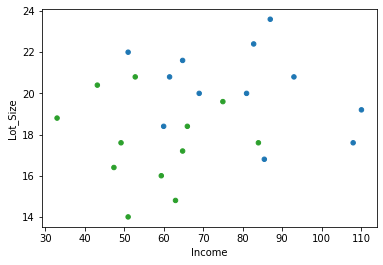

In [12]:
#  Do a scatter plot: Lot size vs. Income (see if you can differentiate by Owner vs. Nonowner)
mower_df.plot.scatter(x='Income', y='Lot_Size', 
                        c=['C0' if c == 'Owner' else 'C2' for c in mower_df.Ownership])
plt.show()

Initialize normalized training, validation, and complete data frames. Use the training data to learn the transformation.

In [18]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income', 'Lot_Size']])  # Note the use of an array of column names

# Transform the full dataset
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]), 
                                    columns=['zIncome', 'zLot_Size']),
                       mower_df[['Ownership', 'Number']]], axis=1)


In [23]:
trainNorm = mowerNorm.iloc[trainData.index]
#Similarly, get the valid one as well
validNorm = mowerNorm.iloc[validData.index]
trainNorm.head()

#Scale the new data
newNorm = pd.DataFrame(scaler.transform(newHousehold[['Income', 'Lot_Size']]), 
                                    columns=['zIncome', 'zLot_Size'])
newNorm

,zIncome,zLot_Size
0,-0.275507,0.295182


In [25]:
trainNorm.head()

,zIncome,zLot_Size,Ownership,Number
13,-0.654895,0.625785,Nonowner,13
18,-0.307123,-1.357836,Nonowner,18
3,-0.196468,0.625785,Owner,3
14,-0.022583,-0.861931,Nonowner,14
20,-0.939435,-1.192535,Nonowner,20


Use k-nearest neighbour

In [24]:
knn = KNeighborsClassifier(n_neighbors=3).fit(trainNorm[['zIncome', 'zLot_Size']], trainNorm['Ownership'])
distances, indices = knn.kneighbors(newNorm)
print(knn.predict(newNorm))
print('Distances',distances)
print('Indices', indices)
print(trainNorm.iloc[indices[0], :])

['Owner']
Distances [[0.33992046 0.50322301 0.70793078]]
Indices [[2 0 8]]
     zIncome  zLot_Size Ownership  Number
3  -0.196468   0.625785     Owner       3
13 -0.654895   0.625785  Nonowner      13
2  -0.022583   0.956389     Owner       2


In [28]:
#Try using knn for valid dataset
knn.kneighbors(validNorm[['zIncome', 'zLot_Size']])
knn.predict(validNorm[['zIncome', 'zLot_Size']])

array(['Nonowner', 'Owner', 'Owner', 'Owner', 'Owner', 'Owner',
       'Nonowner', 'Nonowner', 'Nonowner', 'Nonowner'], dtype=object)

## Finding the best k
Initialize a data frame with two columns: `k` and `accuracy`

In [29]:
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1       0.8
1    2       0.7
2    3       0.8
3    4       0.8
4    5       0.7
5    6       0.8
6    7       0.8
7    8       0.8
8    9       0.7
9   10       0.8
10  11       0.8
11  12       0.7
12  13       0.6
13  14       0.5


In [10]:
# Retrain with full dataset using the best k
